In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('./Assets/data_.csv', index_col = 'Date')
data.head()

,High,Low,Open,Close,Volume,Adj Close,pct_change,log_change,volume_change,volume_log_change,...,NASDQ,dealer_buy,dealer_sell,dealer_dif,investment_buy,investment_sell,investment_dif,foreign_buy,foreign_sell,foreign_dif
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-10,59.2,58.2,59.0,58.4,53679000.0,38.37,-0.003413,-0.003419,0.173209,0.159743,...,2147.87,3161497580,2968407011,193090569,3102476560,1648311871,1454164689,1.551380e+10,2.549564e+10,-9981838210
2010-02-22,60.5,59.0,60.5,59.0,47519000.0,38.76,0.010274,0.010222,-0.114756,-0.121892,...,2242.03,3133892869,2444166818,689726051,2130761100,1359109401,771651699,2.846749e+10,2.503619e+10,3431302085
2010-02-23,59.9,59.1,59.6,59.8,50343000.0,39.29,0.013559,0.013468,0.059429,0.057730,...,2213.44,2000150200,2287498353,-287348153,2263043520,2650742656,-387699136,2.422218e+10,2.360860e+10,613580581
2010-02-24,59.2,58.4,59.2,58.5,54884000.0,38.43,-0.021739,-0.021979,0.090201,0.086362,...,2235.90,2043898760,1998239251,45659509,2258613250,1775532693,483080557,2.027639e+10,2.546846e+10,-5192069643
2010-02-25,58.9,57.9,58.5,58.2,55655000.0,38.24,-0.005128,-0.005141,0.014048,0.013950,...,2234.22,1728179056,3572176638,-1843997582,1801497370,2286138110,-484640740,2.259238e+10,3.143820e+10,-8845826819


In [3]:
data['y'] = data['log_change']
from Tools.train_test_split import train_test_split

train_x, train_y, test_x, test_y, x_scaler, y_scaler = train_test_split(data, 60, 20, 0.8)

train_x: (2324, 60) train_y: (2324, 1)
test_x: (602, 60) test_y: (602, 1)


[1/200] Loss: 829.2729601860046
[2/200] Loss: 749.5456380844116
[3/200] Loss: 677.9967827796936
[4/200] Loss: 616.0534996986389
[5/200] Loss: 564.2359457015991
[6/200] Loss: 516.6685781478882
[7/200] Loss: 467.6949863433838
[8/200] Loss: 418.00452613830566
[9/200] Loss: 378.1368160247803
[10/200] Loss: 343.8175263404846
[11/200] Loss: 303.0957009792328
[12/200] Loss: 255.57880854606628
[13/200] Loss: 220.9440472126007
[14/200] Loss: 200.9237675666809
[15/200] Loss: 181.5394217967987
[16/200] Loss: 156.202073097229
[17/200] Loss: 130.61680793762207
[18/200] Loss: 112.76913189888
[19/200] Loss: 106.31526970863342
[20/200] Loss: 106.21580076217651
[21/200] Loss: 101.4347493648529
[22/200] Loss: 85.6021420955658
[23/200] Loss: 72.4560557603836
[24/200] Loss: 68.88246655464172
[25/200] Loss: 61.6960608959198
[26/200] Loss: 60.788570165634155
[27/200] Loss: 63.14556574821472
[28/200] Loss: 63.0412859916687
[29/200] Loss: 59.87882286310196
[30/200] Loss: 54.737444162368774
[31/200] Loss: 50.5

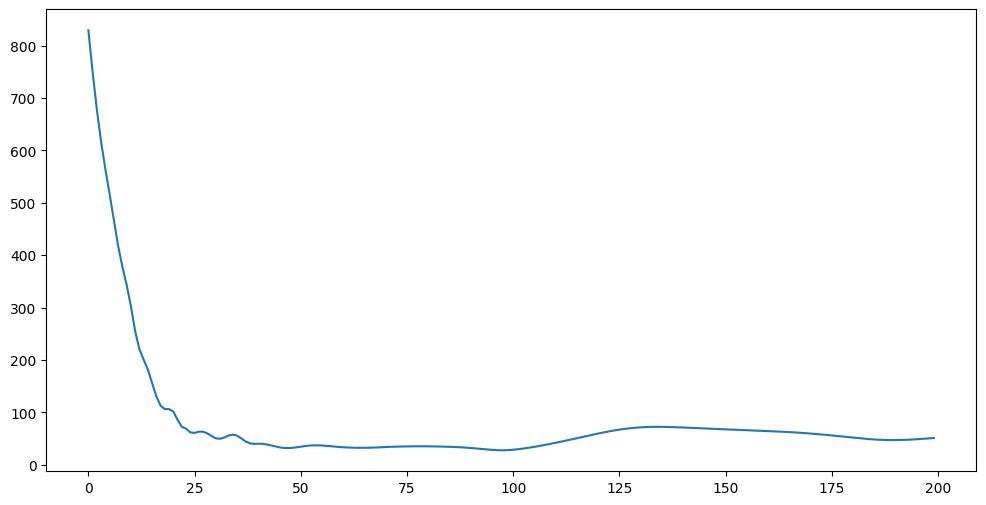

In [4]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float()), batch_size = 128, shuffle = True)

use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

from Models.VAE import VAE

model_vae = VAE([60, 45, 30, 20], 20)
learning_rate = 0.0001
optimizer = torch.optim.Adam(model_vae.parameters(), lr = learning_rate)
epochs = 200
hist = np.zeros(epochs)

for epoch in range(epochs):
    loss_ = []
    for idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        output, z, mu, logVar = model_vae(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, epochs), sum(loss_))
plt.figure(figsize=(12, 6))
plt.plot(hist)


In [5]:
# In this section we use vae to transform the feature, and prepare the data
# for GAN. The discriminator will use a true data in sequence length of 7.
from Tools.gan_make_data import gan_make_data

model_vae.eval()

output, latent_train_x, mu, logVar = model_vae(torch.from_numpy(train_x).to(device).float()) # 20 feature




gan_train_x, gan_train_y, y_label = gan_make_data(20, latent_train_x.detach().cpu().numpy(), train_y)
gan_train_loader = DataLoader(TensorDataset(torch.from_numpy(gan_train_x).float(), torch.from_numpy(gan_train_y).float()), batch_size = 128, shuffle = True)

output, latent_test_x, mu, logVar = model_vae(torch.from_numpy(test_x).to(device).float()) 
gan_test_x, gan_test_y, y_label_test = gan_make_data(20, latent_test_x.detach().cpu().numpy(), test_y)
gan_test_loader = DataLoader(TensorDataset(torch.from_numpy(gan_test_x).float(), torch.from_numpy(y_label_test).float()), batch_size = 128, shuffle = True)

[1/200] LossD: 24.8733092546463 LossG:12.691731691360474
[2/200] LossD: 24.46139121055603 LossG:12.889039814472198
[3/200] LossD: 24.012776970863342 LossG:13.109271943569183
[4/200] LossD: 23.461024165153503 LossG:13.376688778400421
[5/200] LossD: 22.757440090179443 LossG:13.66915488243103
[6/200] LossD: 21.826826810836792 LossG:14.157022893428802
[7/200] LossD: 20.862436413764954 LossG:14.549261808395386
[8/200] LossD: 20.017011880874634 LossG:14.999236166477203
[9/200] LossD: 20.01123559474945 LossG:14.946007490158081
[10/200] LossD: 20.95202088356018 LossG:14.405267000198364
[11/200] LossD: 23.316789984703064 LossG:13.222949922084808
[12/200] LossD: 26.04130208492279 LossG:11.948145627975464
[13/200] LossD: 26.96953308582306 LossG:12.084738492965698
[14/200] LossD: 26.631954550743103 LossG:12.670775592327118
[15/200] LossD: 25.96567678451538 LossG:13.120737850666046
[16/200] LossD: 25.5255229473114 LossG:13.02627283334732
[17/200] LossD: 25.12892735004425 LossG:12.833554923534393
[1

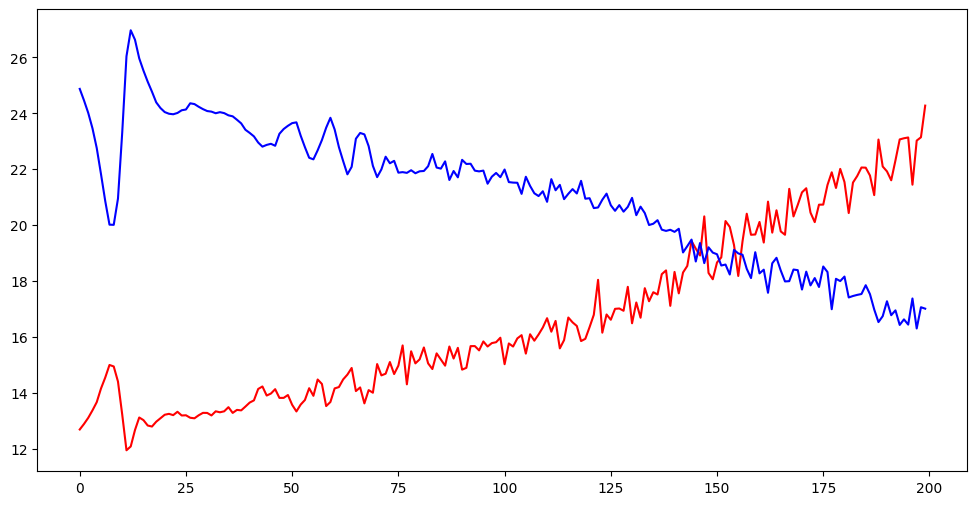

In [6]:
from Models.GAN import generator, discriminator

batch_size = 128
optimizer_betas = (0.9, 0.999)
epochs = 200

gen = generator(20, 100, 2, 1, 0.2).to(device)
dis = discriminator([7, 32, 64, 128], batch_size).to(device)

learning_rate = 0.00005
criterion = nn.BCELoss()
optimizer_generator = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=optimizer_betas)
optimizer_discriminator = torch.optim.Adam(dis.parameters(), lr=learning_rate, betas=optimizer_betas)
loss_g = np.zeros(epochs)
loss_d = np.zeros(epochs)

for epoch in range(epochs):
    lossG_ = []
    lossD_ = []
    for idx, (x, y) in enumerate(gan_train_loader):
        x = x.to(device)
        y = y.to(device)
        dis_real_output = dis(y)
        real_labels = torch.ones_like(dis_real_output)
        lossD_real = criterion(dis_real_output, real_labels)

        fake_data = gen(x)
        fake_data = torch.cat([y[:, :6, :], fake_data.reshape(batch_size, 1, 1)], axis = 1)
        dis_fake_output = dis(fake_data)
        fake_labels = torch.zeros_like(real_labels)
        lossD_fake = criterion(dis_fake_output, fake_labels)
        
        lossD = (lossD_real + lossD_fake)

        dis.zero_grad()
        lossD.backward(retain_graph=True)
        optimizer_discriminator.step()
        lossD_.append(lossD.item())

        output_fake = dis(fake_data)
        lossG = criterion(output_fake, real_labels)
        gen.zero_grad()
        lossG.backward()
        optimizer_generator.step()
        lossG_.append(lossG.item())        
    loss_g[epoch] = sum(lossG_) 
    loss_d[epoch] = sum(lossD_)
    print(f'[{epoch+1}/{epochs}] LossD: {sum(lossD_)} LossG:{sum(lossG_)}')

plt.figure(figsize=(12, 6))
plt.plot(loss_g, color = 'red', label = 'lossG')
plt.plot(loss_d, color = 'blue', label = 'lossD')


In [11]:
gan_train_loader = DataLoader(TensorDataset(torch.from_numpy(gan_train_x).float(), torch.from_numpy(gan_train_y).float()), batch_size = 128, shuffle = False)
gan_test_loader = DataLoader(TensorDataset(torch.from_numpy(gan_test_x).float(), torch.from_numpy(y_label_test).float()), batch_size = 128, shuffle = False)

gen.eval()
y_predict = []
for idx, (x, y) in enumerate(gan_train_loader):
    x = x.to(device)
    y = y.to(device)

    predict_y = gen(x)
    y_predict.append(predict_y.detach().numpy())

y_predict_test = []
for idx, (x, y) in enumerate(gan_test_loader):
    x = x.to(device)
    y = y.to(device)

    predict_y_test = gen(x)
    y_predict_test.append(predict_y_test.detach().numpy())        

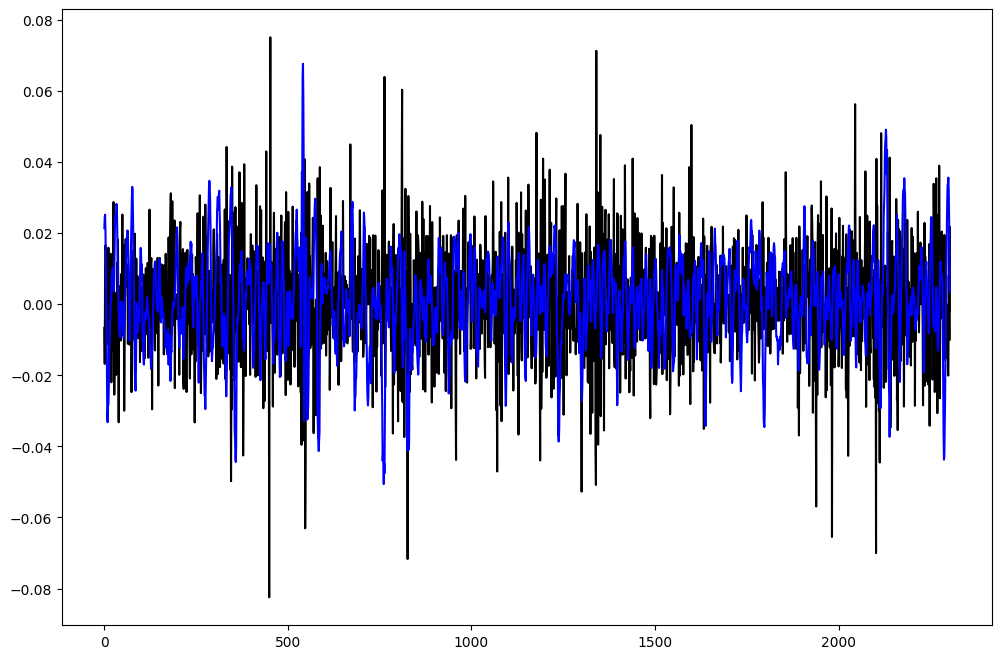

In [12]:
# prediciting training data

predict_price = []
for i in y_predict:
    for j in i:
        predict_price.append(j)

predict_price = np.array(predict_price)
predict_price = y_scaler.inverse_transform(predict_price)
actual_y = y_scaler.inverse_transform(y_label.reshape(-1, 1))

plt.figure(figsize=(12, 8))
plt.plot(actual_y, color = 'black')
plt.plot(predict_price, color = 'blue')

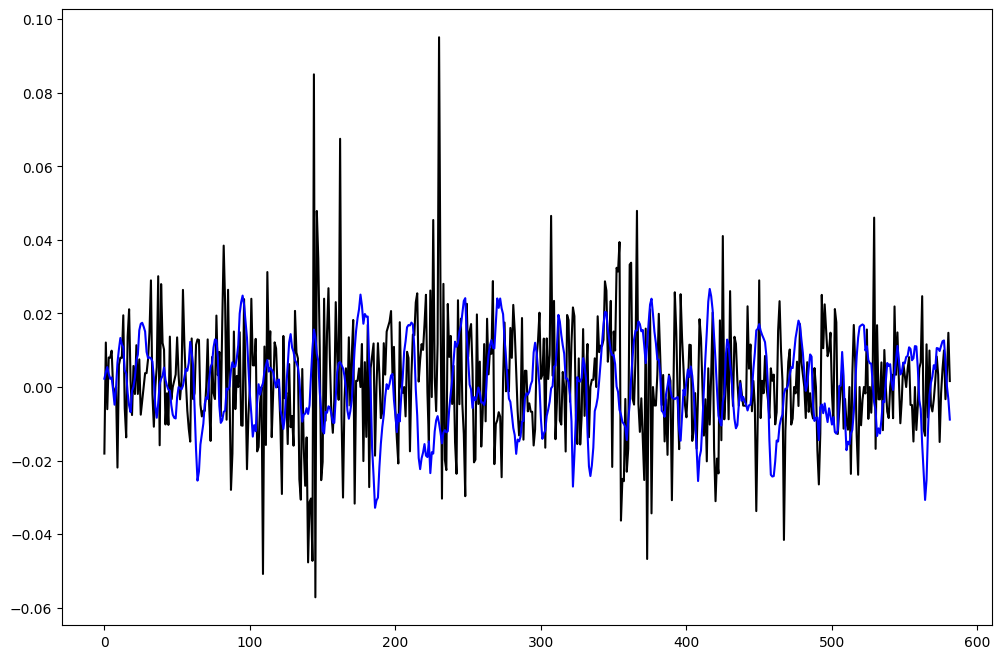

In [13]:
# predicting testing data

predict_price = []
for i in y_predict_test:
    for j in i:
        predict_price.append(j)

predict_price = np.array(predict_price)
predict_price = y_scaler.inverse_transform(predict_price)
actual_y = y_scaler.inverse_transform(y_label_test.reshape(-1, 1))

plt.figure(figsize=(12, 8))
plt.plot(actual_y, color = 'black')
plt.plot(predict_price, color = 'blue')

In [14]:
vae_gan = []
for i in range(actual_y.shape[0]):
    if actual_y[i]* predict_price[i] > 0:
        vae_gan.append(1)
    else:
        vae_gan.append(0)

print(f'VAE + GAN accuracy: {sum(vae_gan)/ len(vae_gan)}')


VAE + GAN accuracy: 0.4570446735395189
